# TRAIN
# Project 3: Collaboration and Competition
## Udacity Deep Reinforcement Learning Nanodegree

### Preliminaries

Import required dependencies:

In [1]:
from agent_controller import AgentController
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import time
from unityagents import UnityEnvironment

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

## The environment

Instantiate the environment and obtain aspects of it.

In [3]:
environment_path = '../Tennis_Linux_NoVis/Tennis.x86_64'

In [4]:
env = UnityEnvironment(file_name=environment_path)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
agents_n = len(env_info.agents)
print(f'agents_n: {agents_n}')

assert agents_n == 2

action_shape_single = brain.vector_action_space_size
action_shape_all = (agents_n, action_shape_single)

states = env_info.vector_observations
state_shape_all = states.shape
state_shape_single = state_shape_all[1]

print(f'state_shape_all: {state_shape_all}')
print(f'state_shape_single: {state_shape_single}')

print(f'action_shape_all: {action_shape_all}')
print(f'action_shape_single: {action_shape_single}')

del env_info
del states

agents_n: 2
state_shape_all: (2, 24)
state_shape_single: 24
action_shape_all: (2, 2)
action_shape_single: 2


## The agent controller

The agent controller implements [MADDPG](https://arxiv.org/abs/1706.02275). This approach does *not* give special consideration to the symmetry that exists between the agents in the game.

In [6]:
def get_agent_controller():
    return AgentController(
        agents_n = agents_n,    
        state_shape_all=state_shape_all, 
        action_shape_all=action_shape_all, 
        buffer_size=int(1e6),
        buffer_size_before_learning=500,
        update_every=1,    
        epochs_n=3,
        batch_size=256,
        noise_weight_start=1,
        noise_weight_factor=0.999,
        noise_weight_min=0.1,
        gamma=0.99,
        tau=0.01,
        actor_learning_rate=3e-4,
        critic_learning_rate=3e-4
    )

In [7]:
agent_controller_1 = get_agent_controller()

## The environment-agent interaction

Define the success criteria.

In [8]:
SOLVED_SCORE = 0.5
WINDOW_SIZE = 100

Wrap the code that performs training over opisodes:

In [9]:
VERBOSE = True

In [10]:
def run(env, brain_name, agent_controller, checkpoint_name=None):
    """Drives the interaction between the environment and the agent controller.

    Params
    ======
        env: The environment.
        brain_name: The brain name to use in the environment.
        agent_controller: The agent controller to train.
        checkpoint_name: If a solution is reached, the network weights are stored in a file named after this parameter.
        
    Returns
    =======
        scores: The list of scores achieved at every episode.
        rolling_mean: A list of rolling means scores over a window of size "WINDOW_SIZE".
        rolling_std: A list of rolling standard deviation scores over a window of size "WINDOW_SIZE".
    """

    verbose_regularity = 100
    max_episodes = 10000
    max_steps = 10000    

    scores = []
    scores_window = deque(maxlen=WINDOW_SIZE)    
    rolling_scores_mean = []    
    rolling_scores_std = []    
    timer_window = deque(maxlen=WINDOW_SIZE)
    
    def get_output_string():
        """A convenience function that returns a string sumarizing the agent controller's performance over the window.
        """
        return f'Episode {i + 1}: score: {latest_score:.4f}; steps: {t}; mean_score: {mean_score_in_window:.4f}; std_score: {std_score_in_window:.4f}; avg_time: {np.mean(timer_window):.2f}'

    #####

    for i in range(max_episodes):
        timer_start = time.process_time()
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        latest_scores = np.zeros(agents_n)    
        t = 0
        while True:
            actions = agent_controller.act(states)            
            actions = np.clip(actions, -1, 1)                     
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = np.array(env_info.rewards)
            dones = np.array(env_info.local_done, dtype=np.uint8)
            agent_controller.step(states, actions, rewards, next_states, dones)
            states = next_states
            latest_scores += rewards
            if np.any(dones):
                break
            t += 1

        latest_score = np.max(latest_scores)  # Note the maximum here.
        scores.append(latest_score)
        scores_window.append(latest_score)        

        mean_score_in_window = np.mean(scores_window)
        std_score_in_window = np.std(scores_window)

        rolling_scores_mean.append(mean_score_in_window)
        rolling_scores_std.append(std_score_in_window)    

        timer_window.append(time.process_time() - timer_start)

        if VERBOSE and (i + 1) % verbose_regularity == 0:
            print(get_output_string())

        if i >= WINDOW_SIZE - 1 and mean_score_in_window >= SOLVED_SCORE:
            if VERBOSE:
                print(get_output_string())
                print(f'Solved! Number of episodes required: {i - WINDOW_SIZE + 2} to {i + 1}.')

            if checkpoint_name:
                agent_controller.save(path=f'checkpoint_{checkpoint_name}')

            break

    return {
        'scores': scores, 
        'rolling_mean': rolling_scores_mean, 
        'rolling_std': rolling_scores_std 
    }

## Training the agent controller

In [11]:
sc_1 = run(env, brain_name, agent_controller_1, "agent_controller")

Episode 100: score: 0.0000; steps: 13; mean_score: 0.0104; std_score: 0.0296; avg_time: 0.65
Episode 200: score: 0.0000; steps: 14; mean_score: 0.0078; std_score: 0.0265; avg_time: 0.92
Episode 300: score: 0.2000; steps: 89; mean_score: 0.0750; std_score: 0.0916; avg_time: 2.02
Episode 400: score: 0.1000; steps: 31; mean_score: 0.0736; std_score: 0.0712; avg_time: 1.78
Episode 500: score: 0.1000; steps: 30; mean_score: 0.0982; std_score: 0.0510; avg_time: 2.12
Episode 600: score: 0.1000; steps: 29; mean_score: 0.0983; std_score: 0.0420; avg_time: 2.02
Episode 700: score: 0.0000; steps: 12; mean_score: 0.1226; std_score: 0.0736; avg_time: 2.59
Episode 800: score: 0.1000; steps: 29; mean_score: 0.3184; std_score: 0.4677; avg_time: 7.24
Episode 841: score: 1.1000; steps: 409; mean_score: 0.5038; std_score: 0.7522; avg_time: 11.47
Solved! Number of episodes required: 742 to 841.


## Visualized

In [12]:
def visualise_single_training(scores, title):
    """Visualizes a single training of an agent controller. Specifically, the raw scores per epsiode are displayed, as well as
    the rolling mean of scores over a window of episodes.
    """
    plt.plot(scores['scores'], color='gray', label='Episode')
    plt.plot(scores['rolling_mean'], color='blue', label='Rolling mean')
        
    plt.title(title)
    plt.ylabel('score')
    plt.xlabel('episode')
    plt.xlim(left=0)
    plt.axhline(y=SOLVED_SCORE, color='red', linestyle='-')
    plt.axvline(x=len(scores) - WINDOW_SIZE, color='red', linestyle='-')
    
    plt.legend(loc='upper left')
    
    plt.show()   

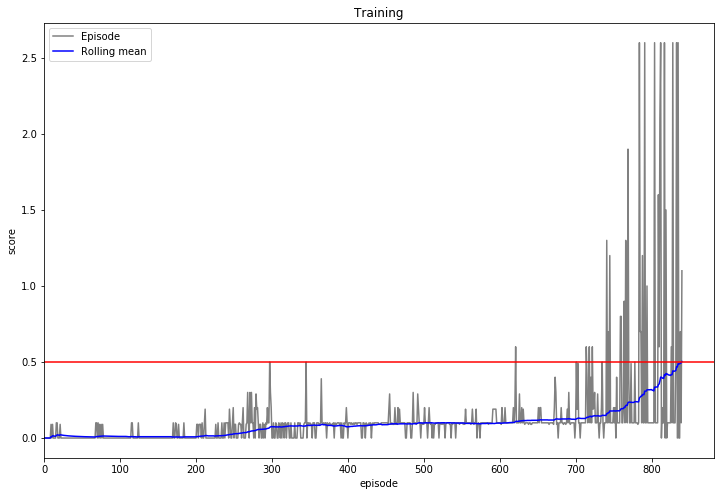

In [13]:
visualise_single_training(sc_1, 'Training')